# Rapid Refresh Model Plotting 

This notebook gives several examples of plotting model analyses from the RAP model.

In [92]:
#Required Libraries
from datetime import datetime, timedelta

from model_functions import *

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors

from metpy.plots import StationPlot
from metpy.units import units
import metpy.calc as mpcalc

import numpy as np

from netCDF4 import Dataset, num2date

from scipy.ndimage import gaussian_filter

from xarray.backends import NetCDF4DataStore
import xarray as xr

import pandas as pd

In [37]:
#set time to plot (no leading zeros)
start_year  = 2021
start_month = 12
start_day   = 10
start_hour  = 18
start_min   = 0
    
#location to plot
#location = True
location_lat = 37.5
location_lon = -98.5J
#    OR
#analysis bounds
location = False
lat_min = 30
lat_max = 50
lon_min = -115
lon_max = -75

In [41]:
dt = datetime(start_year,start_month,start_day,start_hour)
ncss = get_rap_dataset(dt)
print(ncss)

In [42]:
query = ncss.query()
query.lonlat_box(north=lat_max,south=lat_min,east=lon_max,west=lon_min)
query.all_times()
query.add_lonlat()
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                    'Relative_humidity_isobaric',
                    'u-component_of_wind_isobaric',
                    'u-component_of_wind_height_above_ground',
                    'v-component_of_wind_isobaric',
                    'v-component_of_wind_height_above_ground',
                    'Temperature_isobaric',
                    'MSLP_MAPS_System_Reduction_msl',
                    'Convective_available_potential_energy_surface',
                    'Convective_inhibition_surface',
                    'Absolute_vorticity_isobaric',
                    'Potential_temperature_height_above_ground')

data = ncss.get_data(query)
ds = xr.open_dataset(NetCDF4DataStore(data)).metpy.parse_cf()


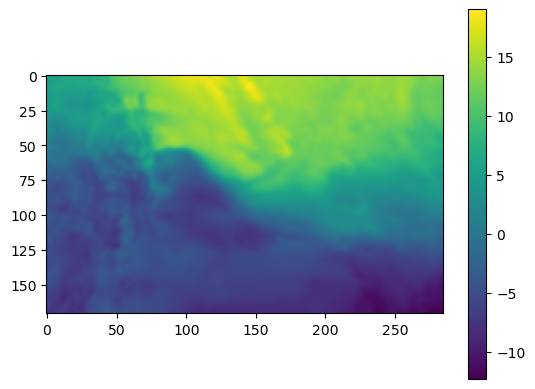

In [136]:
temp = (ds.Temperature_isobaric[0]-273.15)*units('degC')
u = ds['u-component_of_wind_isobaric'][0]*units('m/s')
v = ds['v-component_of_wind_isobaric'][0]*units('m/s')
hght = ds.Geopotential_height_isobaric[0]*units('meters')

plt.imshow(temp.metpy.sel(vertical=850*units('millibars')))
plt.colorbar()


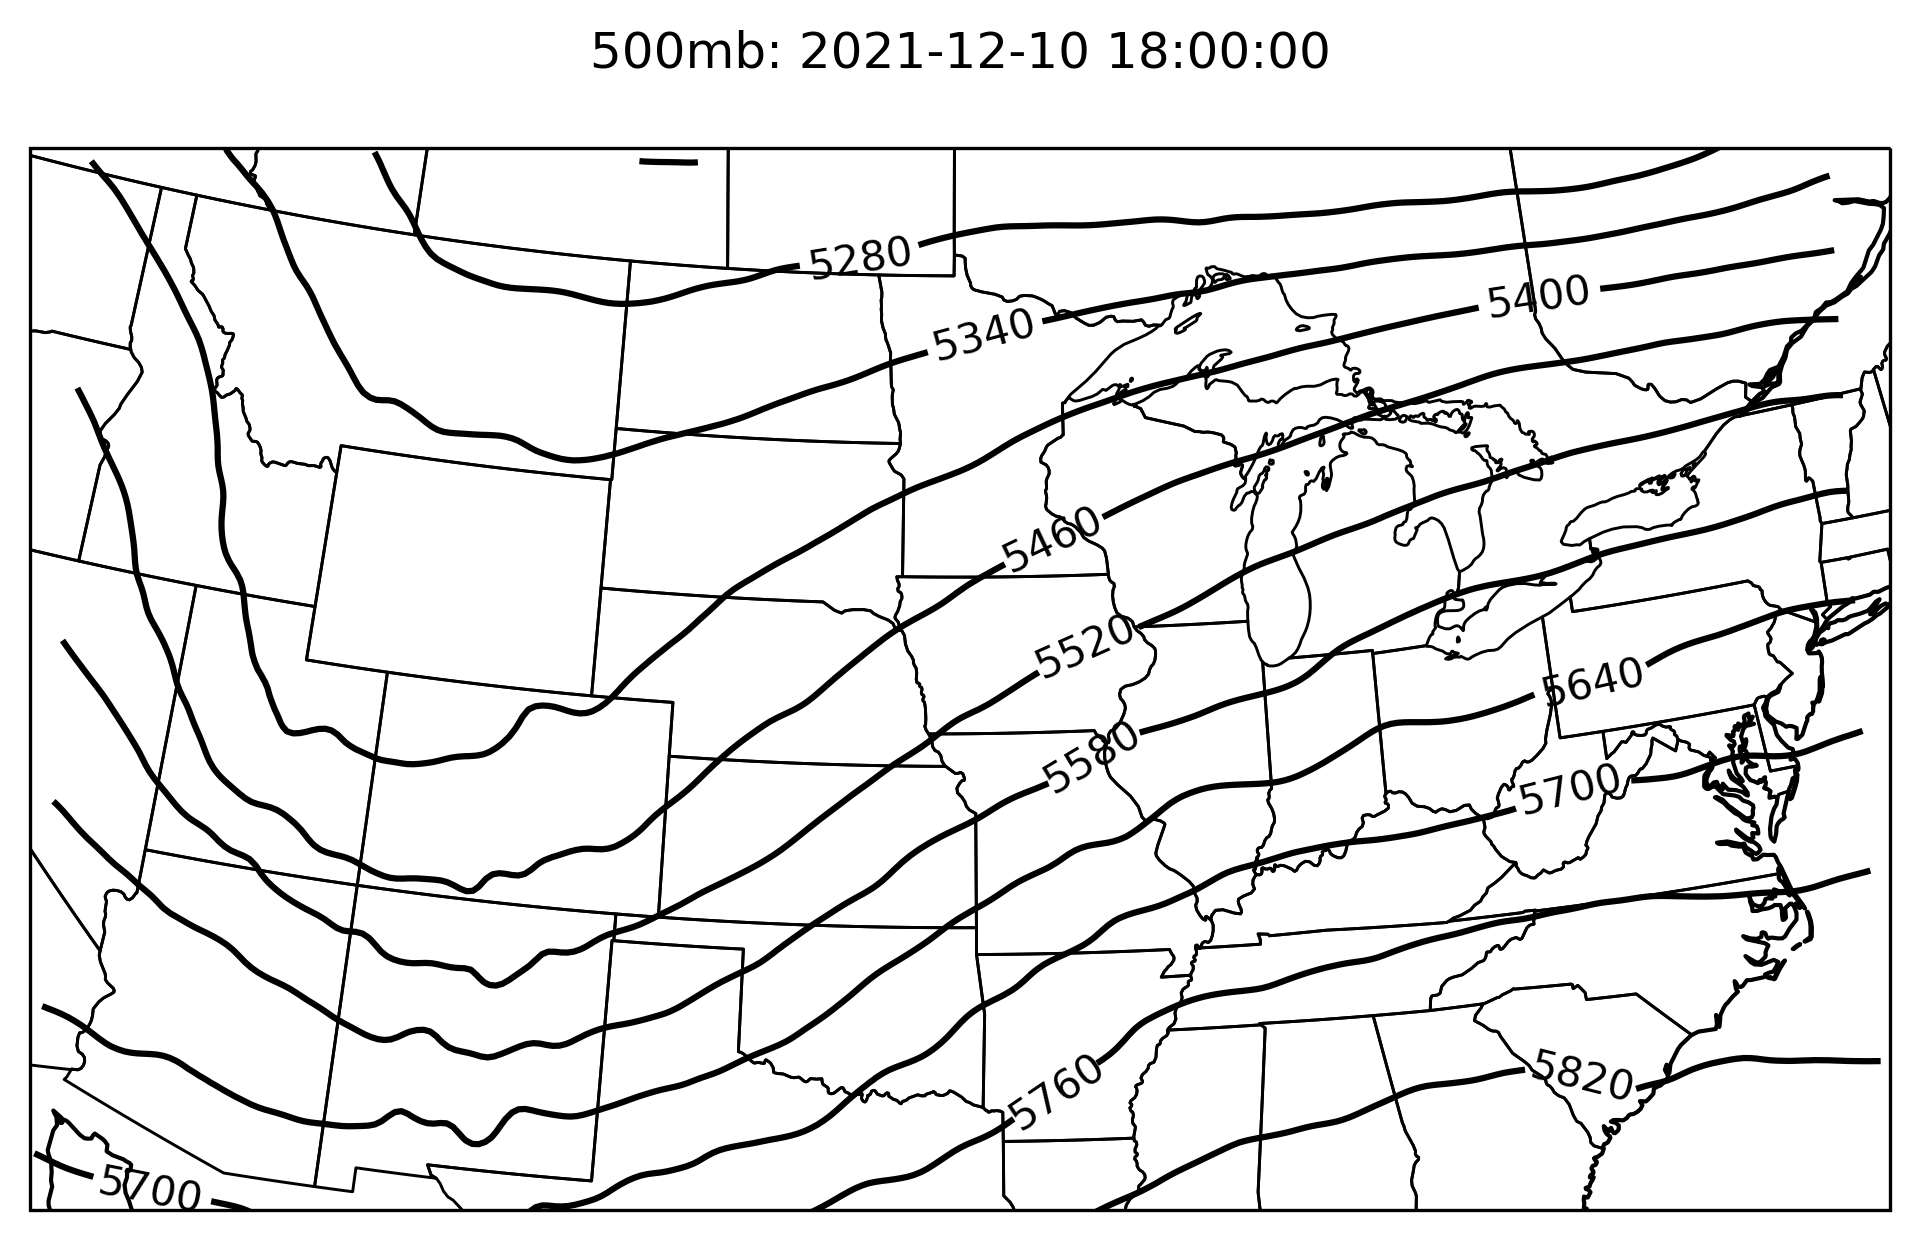

In [225]:
#500mb Chart
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35,standard_parallels=[35])


fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
cs = ax.contour(ds.lon,ds.lat,hght.metpy.sel(vertical=500*units('millibars')),
                   np.arange(0,8000,60),colors='black',transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt="%i", rightside_up=True, use_clabeltext=True)

ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

plt.title(f'500mb: {dt}\n')
plt.savefig(f'500mb_{dt}.png')


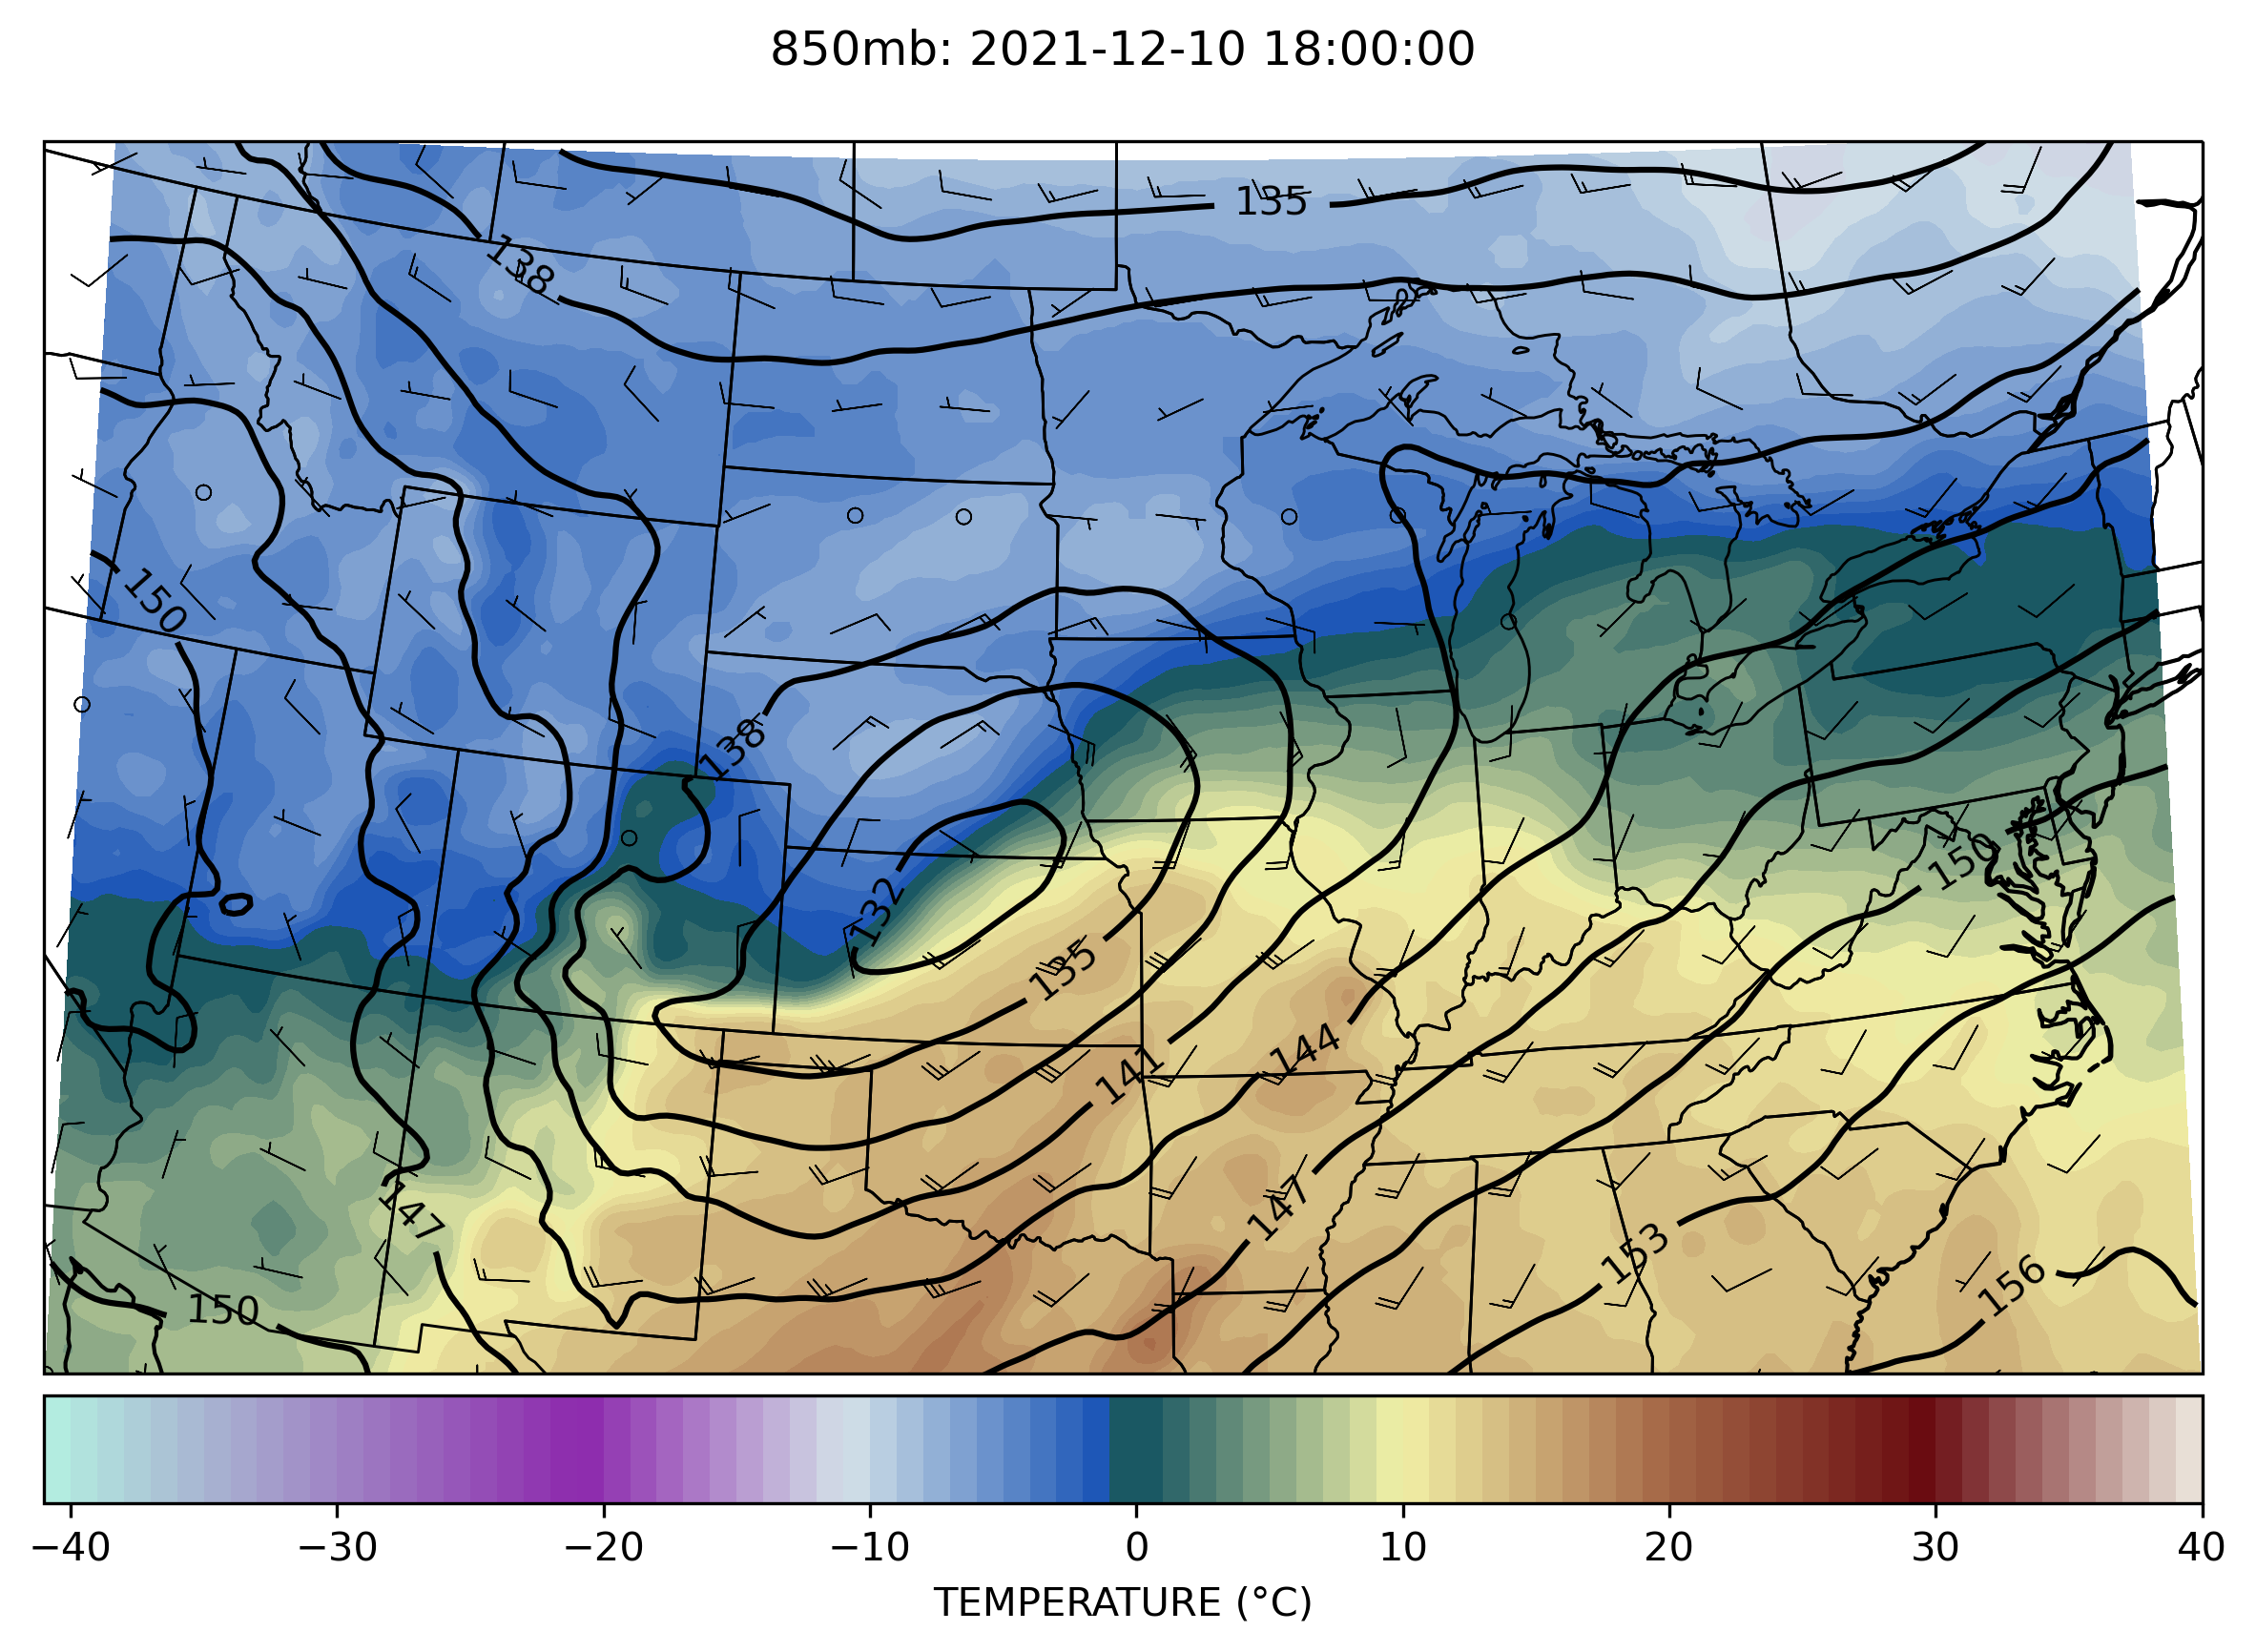

In [226]:
#850mb Chart
colors = [(0.000, '#B3ECE0'),
          (0.125, '#A08AC6'),
          (0.250, '#8C28AC'),
          (0.375, '#D4E2E8'),
          (0.4999,'#1450B4'),
          (0.5001,'#0F505F'),
          (0.625, '#F3F2A7'),
          (0.750, '#A56847'),
          (0.875, '#690B10'),
          (1.000, '#E8DFD6')]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("temps_850",colors,N=80)

proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35,standard_parallels=[35])

fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
ct = ax.contourf(ds.lon,ds.lat,temp.metpy.sel(vertical=850*units('millibars')),
                   np.arange(-41,41,1),cmap=cmap,transform=ccrs.PlateCarree())
cbar = fig.colorbar(ct,location="bottom",ticks=np.arange(-40,41,10),pad=0.01)
cbar.set_label('TEMPERATURE ('+u'\xb0'+'C)')

cs = ax.contour(ds.lon,ds.lat,hght.metpy.sel(vertical=850*units('millibars')),
                   np.arange(0,8000,30),colors='black',transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, 
           fmt=lambda x: f'{x:.0f}'[:3], rightside_up=True, use_clabeltext=True)

wind_slice = (slice(None,None,15),slice(None,None,15))
wb = ax.barbs(ds.lon[wind_slice].values,ds.lat[wind_slice].values,
            u.metpy.sel(vertical=850*units('millibars'))[wind_slice].values*(units('knots')/units('m/s')),
            v.metpy.sel(vertical=850*units('millibars'))[wind_slice].values*(units('knots')/units('m/s')),
            length=5,lw=0.4,pivot='middle',color='black',transform=ccrs.PlateCarree())


ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

fig.tight_layout()

plt.title(f'850mb: {dt}\n')
plt.savefig(f'850mb_{dt}.png')


#Surface Chart
#Frontogenesis
#Theta-E gradient cross section
#Abs Geostrophic momentum cross section
#EPV + RH Cross section


/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/calc/tools.py:1064: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(


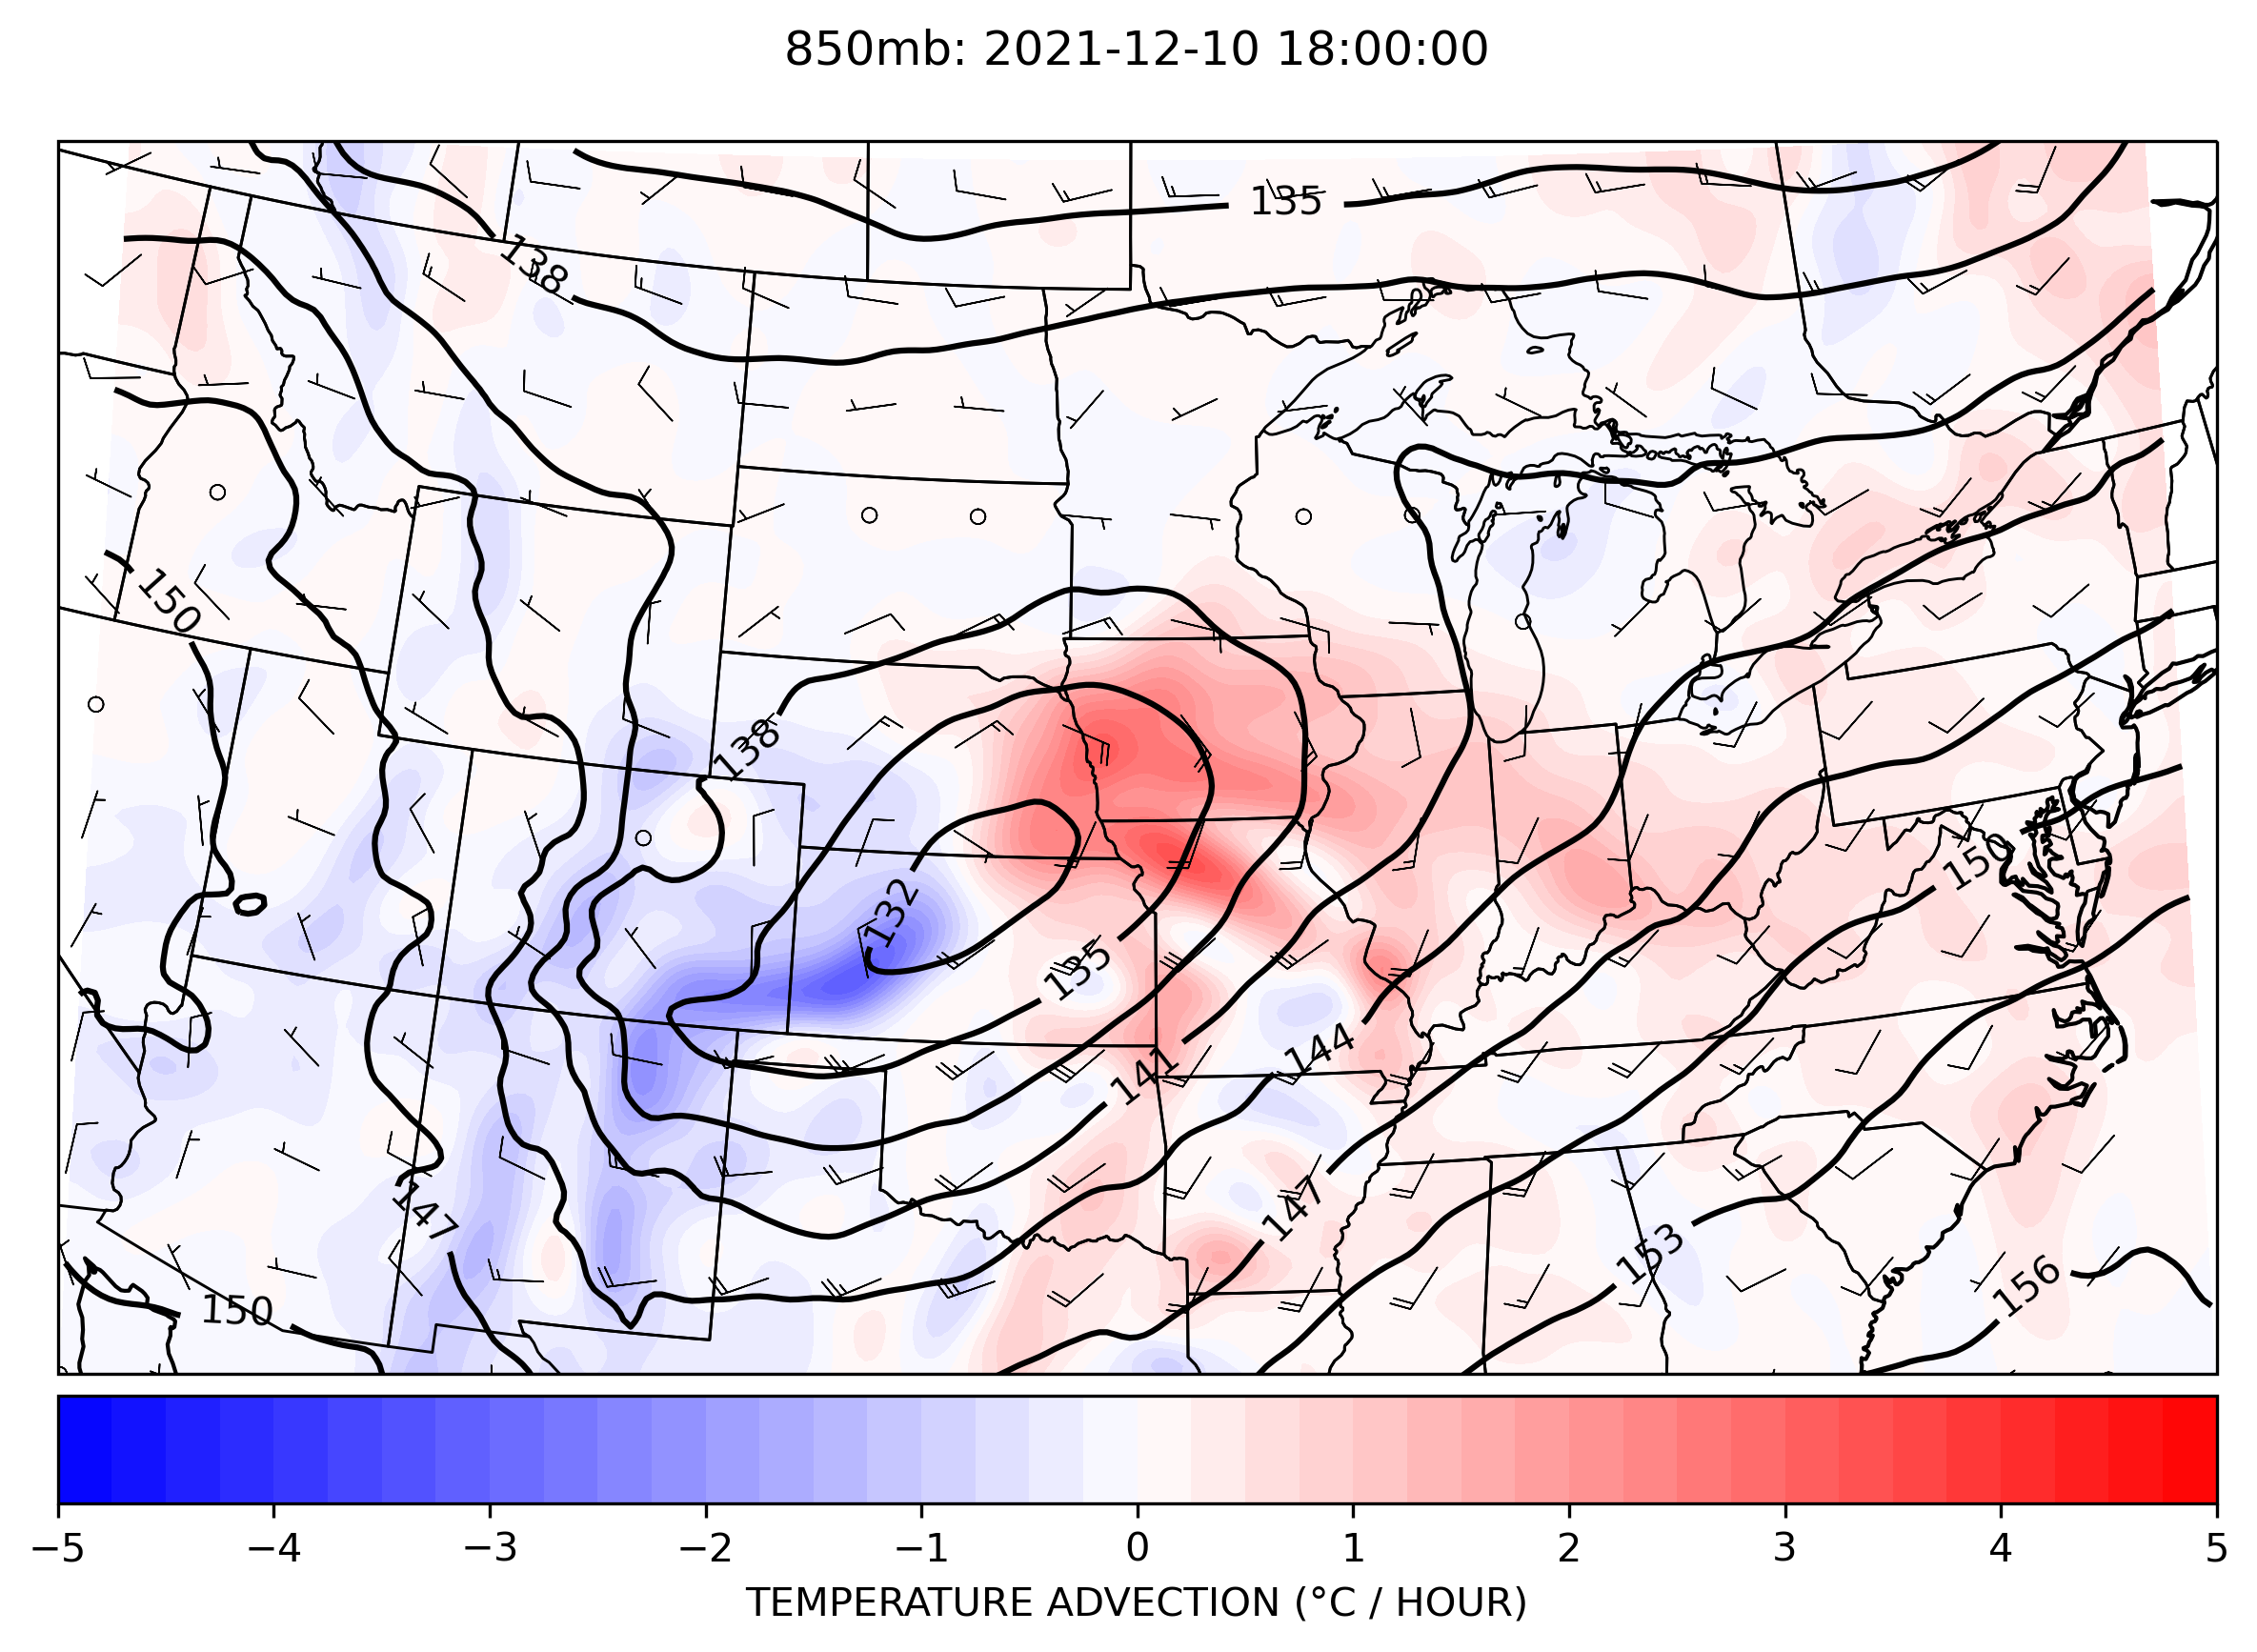

In [227]:
#850mb Temperature Advection

# Calculate temperature advection using metpy function
dx, dy = mpcalc.lat_lon_grid_deltas(ds.lon, ds.lat)
adv = mpcalc.advection(temp.metpy.sel(vertical=850*units('millibars')), 
                       u.metpy.sel(vertical=850*units('millibars')),
                       v.metpy.sel(vertical=850*units('millibars')),
                       latitude=ds.lat,longitude=ds.lon,crs=ccrs.PlateCarree())

adv = gaussian_filter(adv, sigma=3, order=0) * units('K/sec')

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("temps_850",colors,N=80)

proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35,standard_parallels=[35])

fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
cadv = ax.contourf(ds.lon,ds.lat,adv.to(units('delta_degC/hour')),
                   np.arange(-5,5.25,0.25),cmap='bwr',transform=ccrs.PlateCarree())

cbar = fig.colorbar(cadv,location="bottom",ticks=np.arange(-5,6,1),pad=0.01)
cbar.set_label('TEMPERATURE ADVECTION ('+u'\xb0'+'C / HOUR)')


cs = ax.contour(ds.lon,ds.lat,hght.metpy.sel(vertical=850*units('millibars')),
                   np.arange(0,8000,30),colors='black',transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, 
           fmt=lambda x: f'{x:.0f}'[:3], rightside_up=True, use_clabeltext=True)

wind_slice = (slice(None,None,15),slice(None,None,15))
wb = ax.barbs(ds.lon[wind_slice].values,ds.lat[wind_slice].values,
            u.metpy.sel(vertical=850*units('millibars'))[wind_slice].values,
            v.metpy.sel(vertical=850*units('millibars'))[wind_slice].values,
            length=5,lw=0.4,pivot='middle',color='black',transform=ccrs.PlateCarree())



ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

fig.tight_layout()

plt.title(f'850mb: {dt}\n')
plt.savefig(f'850mb_tadv_{dt}.png')

/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/calc/tools.py:1064: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(
/home/jared.marquis/miniconda3/lib/python3.10/site-packages/pint/facets/plain/quantity.py:1119: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magni

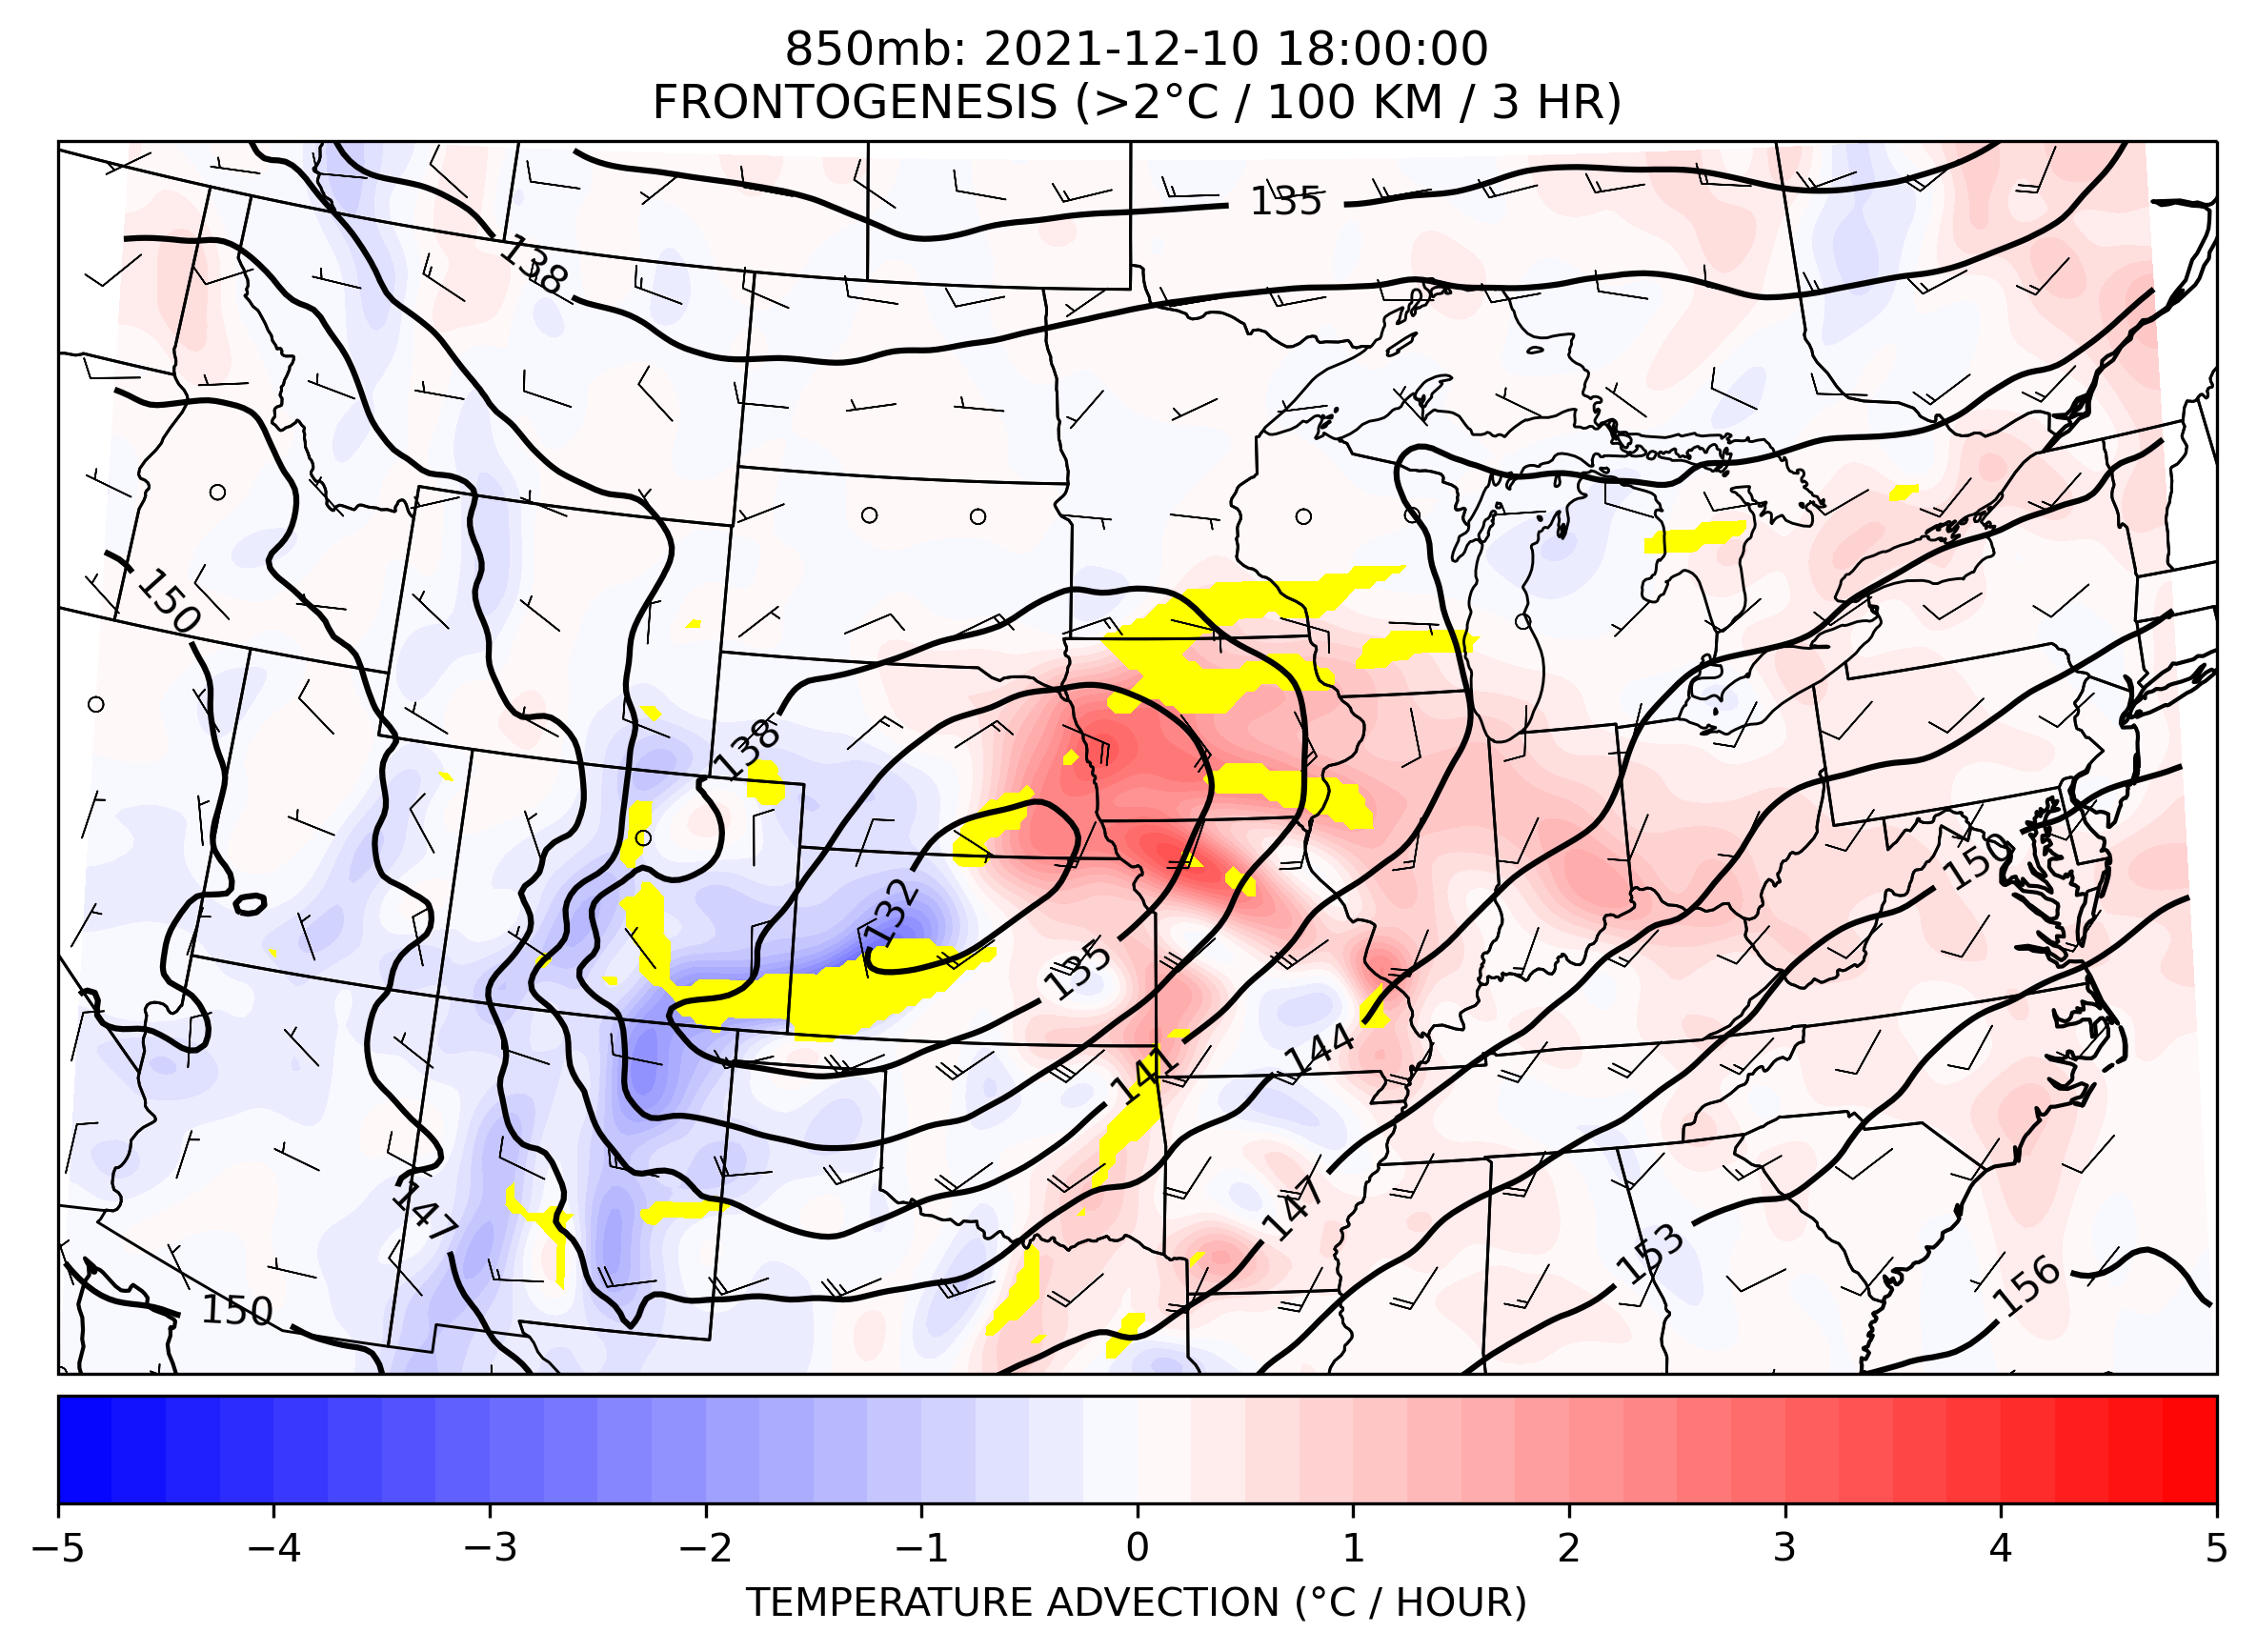

In [228]:
#850mb Frontogenesis

# Calculate temperature advection using metpy function
dx, dy = mpcalc.lat_lon_grid_deltas(ds.lon, ds.lat)
adv = mpcalc.advection(temp.metpy.sel(vertical=850*units('millibars')), 
                       u.metpy.sel(vertical=850*units('millibars')),
                       v.metpy.sel(vertical=850*units('millibars')),
                       latitude=ds.lat,longitude=ds.lon,crs=ccrs.PlateCarree())

fgen = mpcalc.frontogenesis(temp.metpy.sel(vertical=850*units('millibars')), 
                       u.metpy.sel(vertical=850*units('millibars')),
                       v.metpy.sel(vertical=850*units('millibars')),
                       latitude=ds.lat,longitude=ds.lon,crs=ccrs.PlateCarree())


adv = gaussian_filter(adv, sigma=3, order=0) * units('K/sec')
fgen = gaussian_filter(fgen, sigma=1, order=0) * units('K/m/sec')

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("temps_850",colors,N=80)

proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35,standard_parallels=[35])

fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
cadv = ax.contourf(ds.lon,ds.lat,adv.to(units('delta_degC/hour')),
                   np.arange(-5,5.25,0.25),cmap='bwr',transform=ccrs.PlateCarree())

cbar = fig.colorbar(cadv,location="bottom",ticks=np.arange(-5,6,1),pad=0.01)
cbar.set_label('TEMPERATURE ADVECTION ('+u'\xb0'+'C / HOUR)')




fgen = fgen.to(units('delta_degC/km/hour'))*3*100
fgen[fgen.magnitude<2.0]=np.nan
cfgen = ax.contourf(ds.lon,ds.lat,fgen,colors='yellow',transform=ccrs.PlateCarree())


cs = ax.contour(ds.lon,ds.lat,hght.metpy.sel(vertical=850*units('millibars')),
                   np.arange(0,8000,30),colors='black',transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, 
           fmt=lambda x: f'{x:.0f}'[:3], rightside_up=True, use_clabeltext=True)

wind_slice = (slice(None,None,15),slice(None,None,15))
wb = ax.barbs(ds.lon[wind_slice].values,ds.lat[wind_slice].values,
            u.metpy.sel(vertical=850*units('millibars'))[wind_slice].values,
            v.metpy.sel(vertical=850*units('millibars'))[wind_slice].values,
            length=5,lw=0.4,pivot='middle',color='black',transform=ccrs.PlateCarree())



ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

fig.tight_layout()

plt.title(f'850mb: {dt}\n' + 'FRONTOGENESIS (>2'+u'\xb0'+'C / 100 KM / 3 HR)')
plt.savefig(f'850mb_fgen_{dt}.png')